In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import os
import json
%matplotlib inline
%pylab inline
import geopandas as gpd
import zipfile 
import csv

from sklearn.cluster import KMeans
import scipy.cluster as scp

from sklearn.metrics import silhouette_samples, silhouette_score

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# 1. get and prep your data
## Read in NYC Zipcode shp as GeoDataFrame

In [2]:
os.system('curl -0 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip')

0

In [3]:
##the census bureau business data 
name = ['00', '01','02','03','04','05','06','07','08','09','10','11','12','13','14','94','95','96','97','98','99']
for year in name:
    filename = 'zbp' + year + 'totals.zip'
    txt_name = 'zbp' + year + 'totals.txt '
    os.system("unzip " + os.getenv("PUIDATA") + "/" +filename)
    os.system("mv " + txt_name + os.getenv("PUIDATA"))

In [4]:
nyczipsshp = gpd.read_file(os.getenv("PUIDATA") + "/ZIP_CODE_040114.shp")
print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "POLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
nyczips = nyczipsshp.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

ZIPCODES: 248 POLYGONS: 263 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 263


In [5]:
nyczipsshp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [6]:
nyczipsshp['ZIPCODE'] = nyczipsshp['ZIPCODE'].astype(str)

In [7]:
#taking the file from the Prof github repository
#downloaded manually.
txt_file = os.getenv("PUIDATA")+ '/zbp94totals.txt'
year_94 = pd.read_csv(txt_file)

In [8]:
year_94.rename(columns = {'est': '94', 'zip': 'ZIP'}, inplace = True)

In [9]:
year_94.head()

,ZIP,name,empflag,emp,qp1,ap,94
0,1001,"Agawam, MA",NaN,6198,33601,155158,439
1,1002,"Amherst, MA",NaN,6073,28924,127367,450
2,1003,"Amherst, MA",NaN,68,367,1604,10
3,1004,"Amherst, MA",NaN,210,844,4302,47
4,1005,"Barre, MA",NaN,678,3010,13521,92


In [10]:
cbs = year_94[['ZIP','94']]

In [11]:
#the census bureau business data 
#renaming columns - lower and high capital letters - for consistency
names = ['00', '01','02','03','04','05','06','07','08','09','10','11','12','13','14','95','96','97','98','99']
for year in names:
    txt_name = os.getenv("PUIDATA")+ '/zbp' + year + 'totals.txt'
    try:
        dt = pd.read_csv(txt_name)[['zip','est']]
        dt.rename(columns = {'est': year, 'zip': 'ZIP'}, inplace = True)
    except:
        dt = pd.read_csv(txt_name)[['ZIP','EST']]
        dt.rename(columns = {'EST': year}, inplace = True)
    try:
        cbs = cbs.merge(dt,on = 'ZIP')
    except:
        print(year)
        

In [12]:
cbs.dropna(inplace = True)

## Merge GeoDataFrame with DataFrame

In [13]:
cbs['ZIP'] = cbs['ZIP'].astype(str)

In [14]:
cbs.head()

,ZIP,94,00,01,02,03,04,05,06,07,...,10,11,12,13,14,95,96,97,98,99
0,1001,439,493,490,490,505,500,509,509,503,...,448,436,453,439,458,439,433,457,444,469
1,1002,450,563,587,566,586,584,589,582,596,...,570,558,572,572,560,467,487,500,490,558
2,1003,10,13,13,15,16,15,12,12,16,...,16,16,15,15,18,10,13,15,14,13
3,1004,47,48,37,23,21,43,31,30,20,...,21,19,16,16,13,48,47,41,31,35
4,1005,92,86,90,94,93,97,94,98,106,...,96,91,94,97,97,95,101,104,95,82


In [15]:
cbs = cbs.merge(nyczipsshp, how = 'right',left_on = 'ZIP', right_on = 'ZIPCODE')

In [16]:
cbs

,ZIP,94,00,01,02,03,04,05,06,07,...,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,10001,6999.0,7317.0,7188.0,7141.0,7084.0,7370.0,7312.0,7415.0,7549.0,...,22413.0,1.779494e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981958.6472873986 213464.4530421346,..."
1,10002,1784.0,2277.0,2543.0,2269.0,2402.0,2551.0,2682.0,2686.0,2685.0,...,81305.0,2.628013e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((991339.8703228086 207576.7837151289,..."
2,10003,3256.0,3683.0,3602.0,3616.0,3704.0,3776.0,3867.0,3909.0,4049.0,...,55878.0,1.553838e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((989830.469142139 207048.1263078749, ..."
3,10004,1115.0,1294.0,1247.0,1253.0,1252.0,1283.0,1260.0,1311.0,1370.0,...,2187.0,4.002521e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981197.408652395 196571.0816452205, ..."
4,10004,1115.0,1294.0,1247.0,1253.0,1252.0,1283.0,1260.0,1311.0,1370.0,...,2187.0,1.202708e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((972696.8446168154 193014.5477478057,..."
5,10004,1115.0,1294.0,1247.0,1253.0,1252.0,1283.0,1260.0,1311.0,1370.0,...,2187.0,7.679616e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((977542.4500830621 188447.2783390433,..."
6,10004,1115.0,1294.0,1247.0,1253.0,1252.0,1283.0,1260.0,1311.0,1370.0,...,2187.0,6.707080e+05,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((971218.3702115566 190710.8587856293,..."
7,10005,1076.0,1287.0,1249.0,1244.0,1200.0,1226.0,1214.0,1259.0,1273.0,...,8107.0,2.082901e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((982595.6794779003 195880.7536295503,..."
8,10006,1061.0,1067.0,1026.0,934.0,862.0,869.0,870.0,874.0,863.0,...,3011.0,1.716641e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981136.3431577235 198082.3837407082,..."
9,10007,1307.0,1327.0,1233.0,1620.0,1603.0,1635.0,1311.0,1292.0,1284.0,...,7323.0,5.327871e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((980538.9073447287 200658.5114624649,..."


In [17]:
cbs.shape

(263, 35)

## Data cleaning

you may need to clean your data: for some NYC zip codes there may be no info
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: we talked about the importance of "whitening" your data.
Whitenings decorrelates the data: it makes the features independent so that the data covariance matrix is the identity matrix.
Whitening your data in time series analysis is in most cases **wrong**: you are modifying your time behaviour. This is because of the strong correlation between features (two consecutive time stamps for the same observation, the same zip code here, are strongly correlated). Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))


In [18]:
len(cbs.ZIP)

263

In [19]:
cleancbs = cbs.dropna()

In [20]:
cleancbs.columns

Index(['ZIP', '94', '00', '01', '02', '03', '04', '05', '06', '07', '08', '09',
       '10', '11', '12', '13', '14', '95', '96', '97', '98', '99', 'ZIPCODE',
       'BLDGZIP', 'PO_NAME', 'POPULATION', 'AREA', 'STATE', 'COUNTY',
       'ST_FIPS', 'CTY_FIPS', 'URL', 'SHAPE_AREA', 'SHAPE_LEN', 'geometry'],
      dtype='object')

In [21]:
cleancbs.head(10)

,ZIP,94,00,01,02,03,04,05,06,07,...,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,10001,6999.0,7317.0,7188.0,7141.0,7084.0,7370.0,7312.0,7415.0,7549.0,...,22413.0,1.779494e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981958.6472873986 213464.4530421346,..."
1,10002,1784.0,2277.0,2543.0,2269.0,2402.0,2551.0,2682.0,2686.0,2685.0,...,81305.0,2.628013e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((991339.8703228086 207576.7837151289,..."
2,10003,3256.0,3683.0,3602.0,3616.0,3704.0,3776.0,3867.0,3909.0,4049.0,...,55878.0,1.553838e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((989830.469142139 207048.1263078749, ..."
3,10004,1115.0,1294.0,1247.0,1253.0,1252.0,1283.0,1260.0,1311.0,1370.0,...,2187.0,4.002521e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981197.408652395 196571.0816452205, ..."
4,10004,1115.0,1294.0,1247.0,1253.0,1252.0,1283.0,1260.0,1311.0,1370.0,...,2187.0,1.202708e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((972696.8446168154 193014.5477478057,..."
5,10004,1115.0,1294.0,1247.0,1253.0,1252.0,1283.0,1260.0,1311.0,1370.0,...,2187.0,7.679616e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((977542.4500830621 188447.2783390433,..."
6,10004,1115.0,1294.0,1247.0,1253.0,1252.0,1283.0,1260.0,1311.0,1370.0,...,2187.0,6.707080e+05,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((971218.3702115566 190710.8587856293,..."
7,10005,1076.0,1287.0,1249.0,1244.0,1200.0,1226.0,1214.0,1259.0,1273.0,...,8107.0,2.082901e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((982595.6794779003 195880.7536295503,..."
8,10006,1061.0,1067.0,1026.0,934.0,862.0,869.0,870.0,874.0,863.0,...,3011.0,1.716641e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981136.3431577235 198082.3837407082,..."
9,10007,1307.0,1327.0,1233.0,1620.0,1603.0,1635.0,1311.0,1292.0,1284.0,...,7323.0,5.327871e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((980538.9073447287 200658.5114624649,..."


In [22]:
vals = cleancbs[name]

In [23]:
#then the standardization will look like:
vals =((vals.T - cleancbs[name].mean(1)) / cleancbs[name].std(1)).T

In [24]:
vals.head()

,00,01,02,03,04,05,06,07,08,09,...,11,12,13,14,94,95,96,97,98,99
0,0.468610,-0.467573,-0.808663,-1.222326,0.853243,0.432324,1.179819,2.152288,1.593481,0.381523,...,-0.184541,-0.126483,0.149292,0.845986,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998
1,-0.486179,0.176049,-0.506095,-0.174982,0.195965,0.522100,0.532058,0.529569,0.544506,0.753631,...,1.094703,1.199265,1.283911,1.244077,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178
2,-0.458882,-0.717175,-0.672532,-0.391918,-0.162325,0.127855,0.261785,0.708216,0.778369,0.867655,...,1.058983,1.234367,1.435260,1.613833,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414
3,-0.032293,-0.420990,-0.371369,-0.379639,-0.123265,-0.313478,0.108300,0.596238,0.645859,0.670669,...,0.877423,1.191688,1.497684,2.117945,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772
4,-0.032293,-0.420990,-0.371369,-0.379639,-0.123265,-0.313478,0.108300,0.596238,0.645859,0.670669,...,0.877423,1.191688,1.497684,2.117945,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772


vals.mean(axis=1) should return 0 (or something very small) everywhere

vals.mean(axis=1).shape should be (260,)

vals.std(axis=1) should return 1 everywhere

vals.std(axis=1).shape

## Clustering with K-means 

In [25]:
km = KMeans(n_clusters=5, random_state=333).fit(vals)
km_df = pd.DataFrame(vals)
km_df['ZIP'] = cleancbs['ZIP']
km_df['km'] = km.labels_

In [26]:
km_df.head()

,00,01,02,03,04,05,06,07,08,09,...,13,14,94,95,96,97,98,99,ZIP,km
0,0.468610,-0.467573,-0.808663,-1.222326,0.853243,0.432324,1.179819,2.152288,1.593481,0.381523,...,0.149292,0.845986,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,10001,3
1,-0.486179,0.176049,-0.506095,-0.174982,0.195965,0.522100,0.532058,0.529569,0.544506,0.753631,...,1.283911,1.244077,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,10002,3
2,-0.458882,-0.717175,-0.672532,-0.391918,-0.162325,0.127855,0.261785,0.708216,0.778369,0.867655,...,1.435260,1.613833,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,10003,1
3,-0.032293,-0.420990,-0.371369,-0.379639,-0.123265,-0.313478,0.108300,0.596238,0.645859,0.670669,...,1.497684,2.117945,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,10004,1
4,-0.032293,-0.420990,-0.371369,-0.379639,-0.123265,-0.313478,0.108300,0.596238,0.645859,0.670669,...,1.497684,2.117945,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,10004,1


In [27]:
km_df = gpd.GeoDataFrame(km_df.merge(nyczipsshp, how = 'right',left_on = 'ZIP', right_on = 'ZIPCODE'))

(905410.75604293647,
 1075212.5382562785,
 112386.35181947277,
 280345.45402395498)

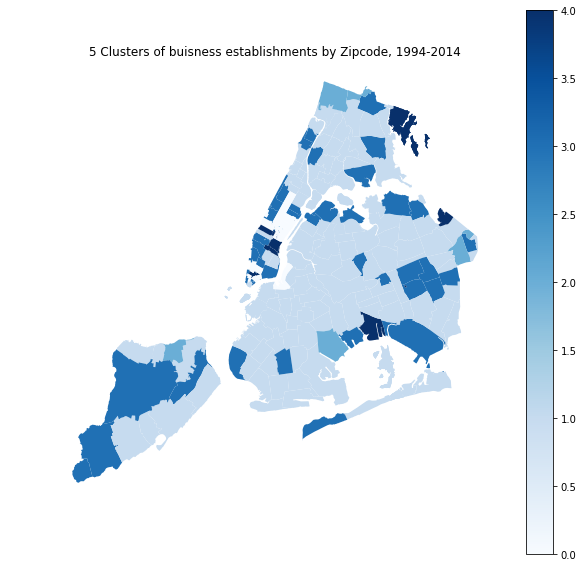

In [28]:
#plotting 
km_df.plot(column ='km',figsize=(10,10), cmap = 'Blues',legend = True)
plt.title('5 Clusters of buisness establishments by Zipcode, 1994-2014')
plt.axis('off')

####  Fig 1: 5 Clusters of buisness establishments by Zipcode, 1994-2014. Each color indicates a cluster. Clusters concentrated in Staten Island, Lower Manhattan and South Brooklyn.

In [29]:
km_df.head()

,00,01,02,03,04,05,06,07,08,09,...,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,0.468610,-0.467573,-0.808663,-1.222326,0.853243,0.432324,1.179819,2.152288,1.593481,0.381523,...,22413.0,1.779494e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981958.6472873986 213464.4530421346,..."
1,-0.486179,0.176049,-0.506095,-0.174982,0.195965,0.522100,0.532058,0.529569,0.544506,0.753631,...,81305.0,2.628013e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((991339.8703228086 207576.7837151289,..."
2,-0.458882,-0.717175,-0.672532,-0.391918,-0.162325,0.127855,0.261785,0.708216,0.778369,0.867655,...,55878.0,1.553838e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((989830.469142139 207048.1263078749, ..."
3,-0.032293,-0.420990,-0.371369,-0.379639,-0.123265,-0.313478,0.108300,0.596238,0.645859,0.670669,...,2187.0,4.002521e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981197.408652395 196571.0816452205, ..."
4,-0.032293,-0.420990,-0.371369,-0.379639,-0.123265,-0.313478,0.108300,0.596238,0.645859,0.670669,...,2187.0,4.002521e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981197.408652395 196571.0816452205, ..."


In [30]:
km_df.columns

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '94', '95', '96', '97', '98', '99', 'ZIP', 'km',
       'ZIPCODE', 'BLDGZIP', 'PO_NAME', 'POPULATION', 'AREA', 'STATE',
       'COUNTY', 'ST_FIPS', 'CTY_FIPS', 'URL', 'SHAPE_AREA', 'SHAPE_LEN',
       'geometry'],
      dtype='object')

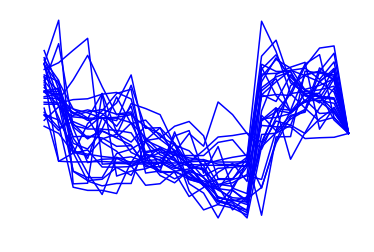

In [31]:
km_dft =km_df[km_df['km'] == 0].drop(['geometry','SHAPE_LEN','SHAPE_AREA','URL','CTY_FIPS','ST_FIPS','COUNTY','STATE','AREA','POPULATION','ZIPCODE','PO_NAME','BLDGZIP','ZIP'], axis = 1).T
km_dft.head()
plt.axis('off')
plt.plot(km_dft,'b')
plt.show()
# plt.plot?

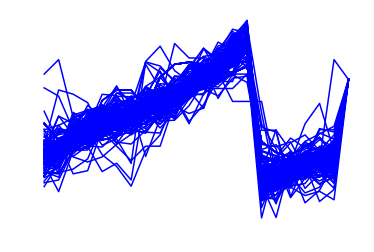

In [32]:
km_dft =km_df[km_df['km'] == 1].drop(['geometry','SHAPE_LEN','SHAPE_AREA','URL','CTY_FIPS','ST_FIPS','COUNTY','STATE','AREA','POPULATION','ZIPCODE','PO_NAME','BLDGZIP','ZIP'], axis = 1).T
km_dft.head()
plt.axis('off')
plt.plot(km_dft,'b')
plt.show()

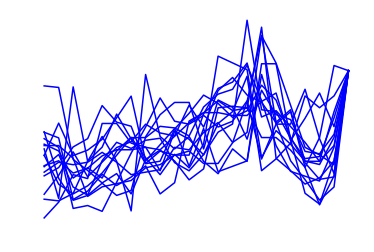

In [33]:
km_dft =km_df[km_df['km'] == 2].drop(['geometry','SHAPE_LEN','SHAPE_AREA','URL','CTY_FIPS','ST_FIPS','COUNTY','STATE','AREA','POPULATION','ZIPCODE','PO_NAME','BLDGZIP','ZIP'], axis = 1).T
km_dft.head()
plt.axis('off')
plt.plot(km_dft,'b')
plt.show()

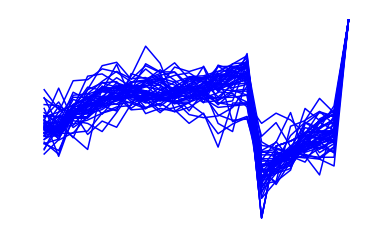

In [34]:
km_dft =km_df[km_df['km'] == 3].drop(['geometry','SHAPE_LEN','SHAPE_AREA','URL','CTY_FIPS','ST_FIPS','COUNTY','STATE','AREA','POPULATION','ZIPCODE','PO_NAME','BLDGZIP','ZIP'], axis = 1).T
km_dft.head()
plt.axis('off')
plt.plot(km_dft,'b')
plt.show()

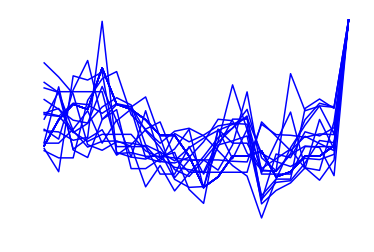

In [35]:
km_dft =km_df[km_df['km'] == 4].drop(['geometry','SHAPE_LEN','SHAPE_AREA','URL','CTY_FIPS','ST_FIPS','COUNTY','STATE','AREA','POPULATION','ZIPCODE','PO_NAME','BLDGZIP','ZIP'], axis = 1).T
km_dft.head()
plt.axis('off')
plt.plot(km_dft,'b')
plt.show()

### Fig. 2 The map of the clusters


In [36]:
# Analyzing Silhouette Score of k from 2 to 8 (code taken from ADS class)
init = 100
seed= 333

for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=seed, n_init=init)
    km_group = kmeans.fit_predict(vals)
    print("K = {} | Silhouette Score = {}".format(k, silhouette_score(vals, km_group)))

K = 2 | Silhouette Score = 0.8354672569495969
K = 3 | Silhouette Score = 0.7652912003207492
K = 4 | Silhouette Score = 0.7065332709988249
K = 5 | Silhouette Score = 0.7510115659908894
K = 6 | Silhouette Score = 0.7289973492620986
K = 7 | Silhouette Score = 0.8005428860126952
K = 8 | Silhouette Score = 0.8244912102457814


## Hierarchical clustering in scipy you can make a dandrogram it may look like this:¶

In [38]:
hi = pd.DataFrame(vals)

In [39]:
hi['ZIP'] = cleancbs['ZIP']

Text(0,0.5,'longitude')

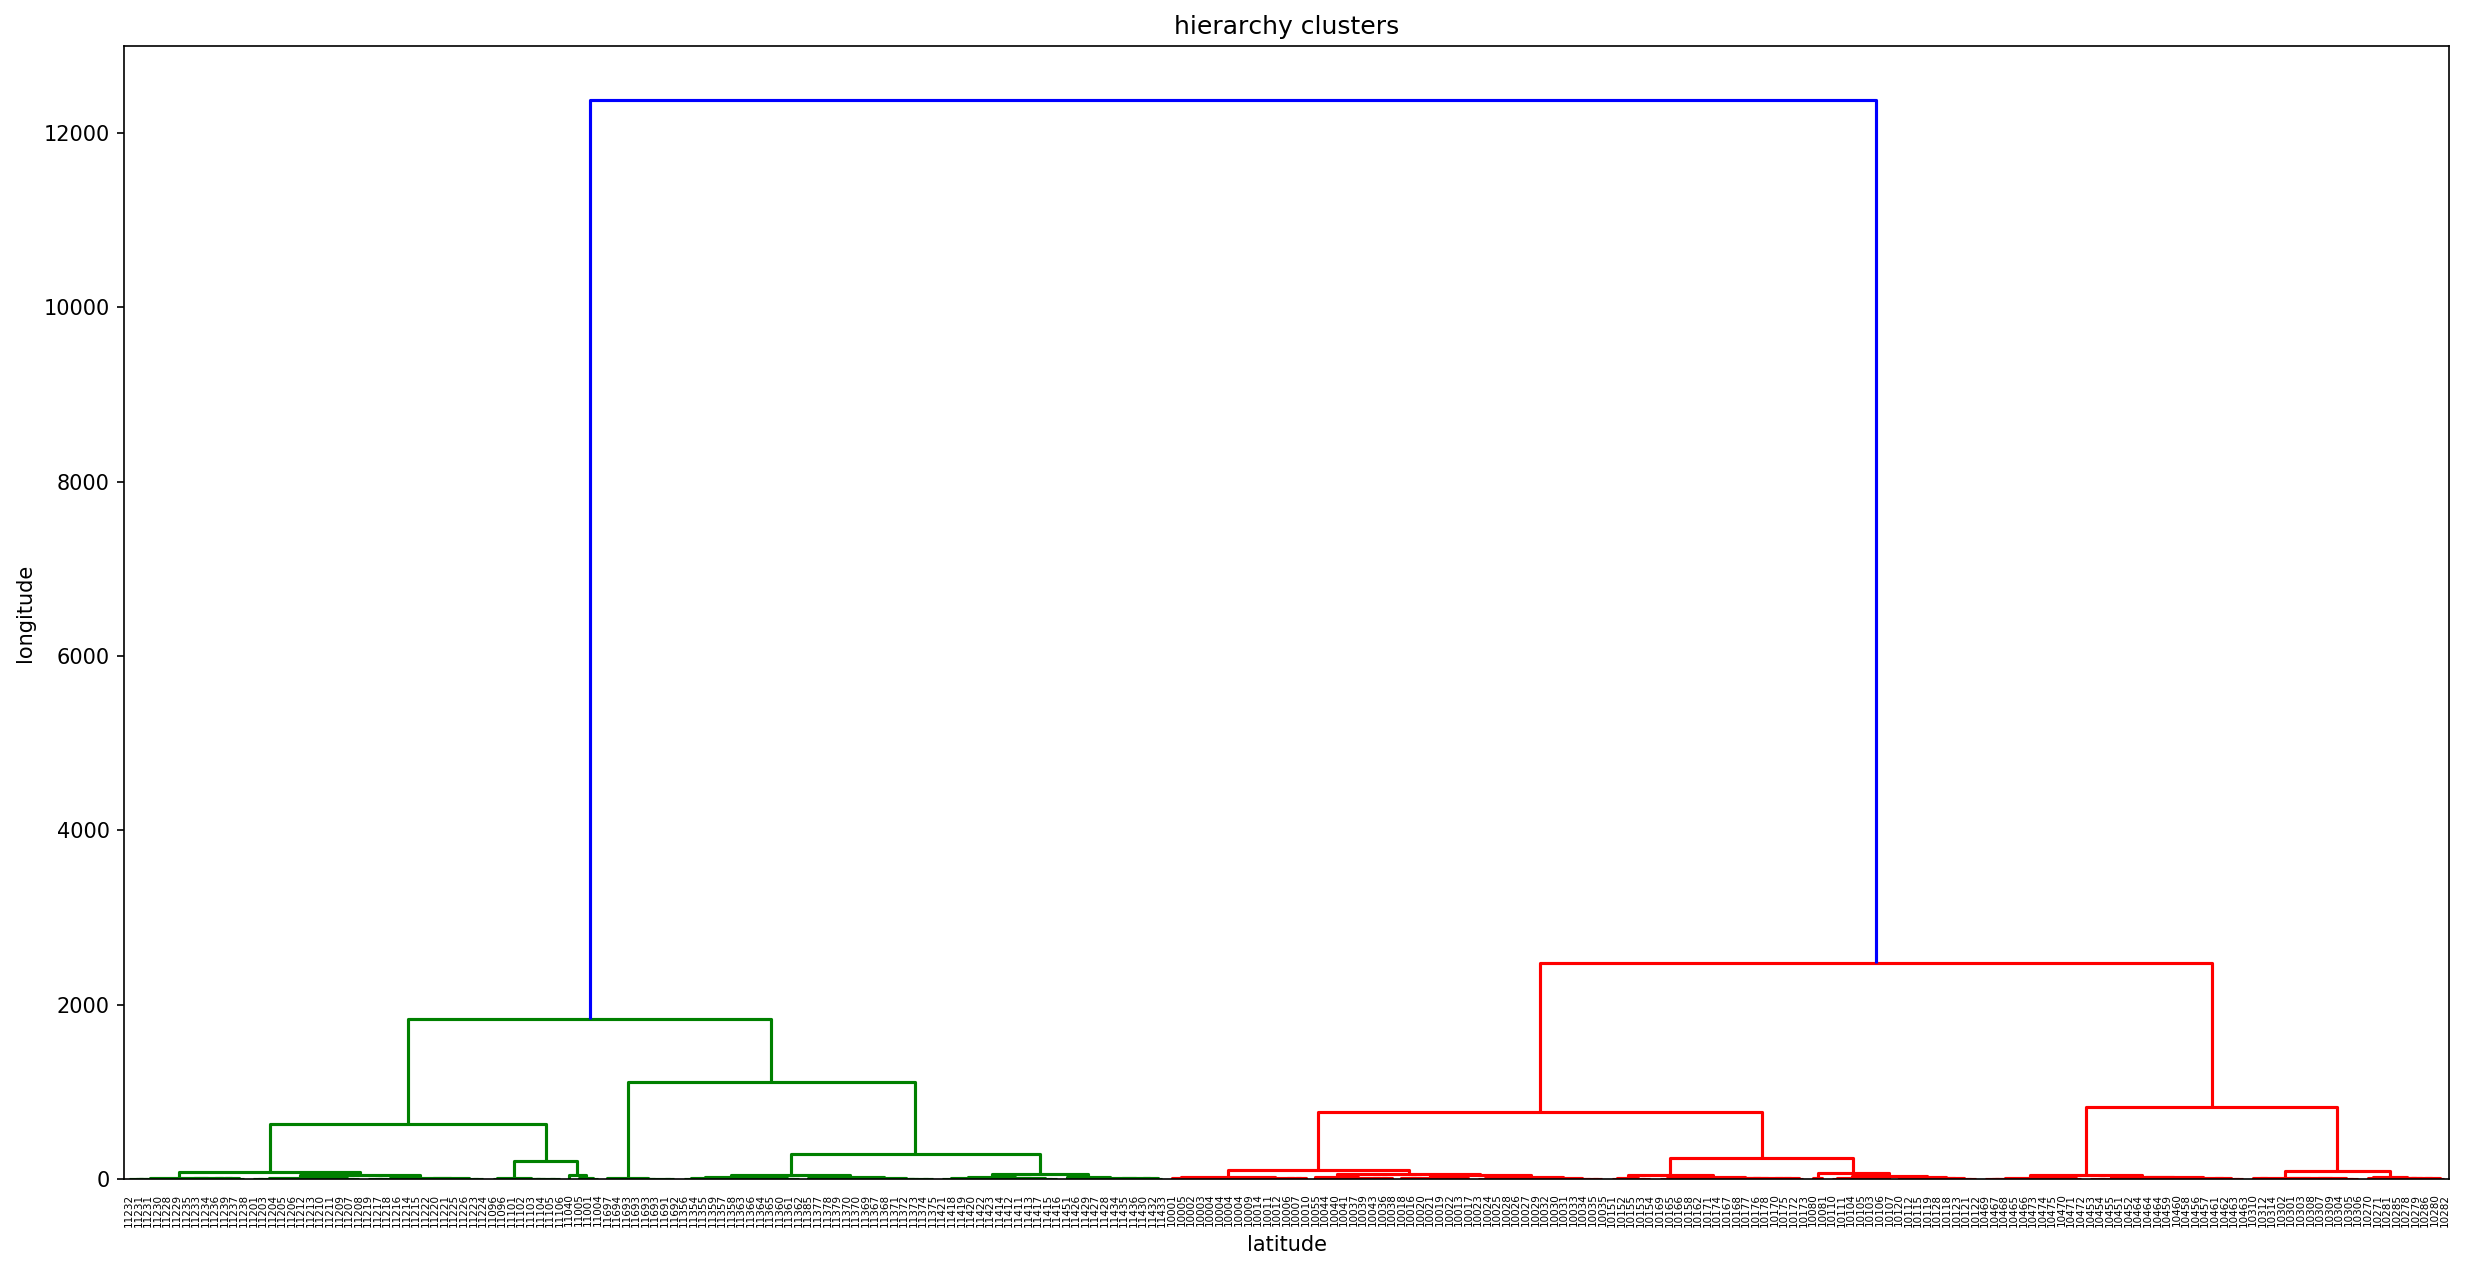

In [40]:
import scipy.cluster as scp
fig = plt.figure(figsize=(20,10), dpi=150)
plt.ylabel("distance")
ddg = scp.hierarchy.dendrogram(scp.hierarchy.linkage(hi, method='ward'),
                               leaf_rotation=90.,
                               labels = np.array(hi['ZIP']))
plt.title('hierarchy clusters')
plt.xlabel('latitude')
plt.ylabel('longitude')

### Fig 3:
Hierarchical clustering for NYC zipcodes.

##  Discussion 

Analyzing the Silhouette Score (the highest score), we see that the best (most appropriate) number of clusters is 2.  

We plotted k=5 so that we had more clusters to analyze. k = 5 has sharp decline of Silhouette Score

According to the hierarchy cluster results, again the NYC zip code can be clustered into 2 big categories (4 smaller ones).